In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# processing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


from sklearn.model_selection import train_test_split
from sklearn import metrics
import io

# Download dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankitverma2010/ecommerce-customer-churn-analysis-and-prediction")

print("Path to dataset files:", path)
path += "/E Commerce Dataset.xlsx"

Path to dataset files: /home/luka-gouvea/.cache/kagglehub/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction/versions/1


In [362]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.pipeline import Pipeline # Essencial para o uso correto com pré-processamento

def evaluate_model_kfold(model, X, y, n_splits=5):
    """
    Avalia um modelo de classificação usando K-Fold Estratificado e retorna
    a média e o desvio padrão de várias métricas.

    Parâmetros:
    ----------
    model : object
        O modelo de machine learning a ser avaliado.
        IMPORTANTE: Para modelos que exigem pré-processamento (ex: escalonamento),
        este deve ser um objeto Pipeline do Scikit-learn.

    X : array-like ou pd.DataFrame
        As features (dados de entrada).

    y : array-like ou pd.Series
        A variável alvo (rótulos).

    n_splits : int, opcional (padrão=5)
        O número de dobras (K) para a validação cruzada.

    Retorna:
    -------
    pd.DataFrame
        Um DataFrame contendo a média e o desvio padrão de cada métrica avaliada.
    """
    # 1. Configurar a validação cruzada estratificada
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 2. Dicionário para armazenar os scores de cada fold
    metrics_results = {
        'AUC': [],
        'F1-Score': [],
        'Recall': [],
        'Precision': [],
        'Accuracy': []
    }

    print(f"Iniciando avaliação com K-Fold ({n_splits} dobras)...")

    # 3. Loop através de cada fold
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"--- Processando Fold {fold + 1}/{n_splits} ---")

        # Separar dados de treino e validação para este fold
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]
        modelo = model
        # 4. Treinar o modelo
        # Se 'model' for um pipeline, ele fará o pré-processamento e o treino
        modelo.fit(X_train_fold, y_train_fold)

        # 5. Fazer previsões no conjunto de validação do fold
        y_pred = modelo.predict(X_val_fold)

        # Para AUC, precisamos das probabilidades
        # Verificamos se o modeloo tem o método `predict_proba`
        if hasattr(modelo, "predict_proba"):
            y_pred_proba = modelo.predict_proba(X_val_fold)[:, 1]
            metrics_results['AUC'].append(roc_auc_score(y_val_fold, y_pred_proba))
        else: # Para modelos como SVC sem probability=True
            metrics_results['AUC'].append(np.nan)


        # 6. Calcular e armazenar as métricas
        metrics_results['F1-Score'].append(f1_score(y_val_fold, y_pred))
        metrics_results['Recall'].append(recall_score(y_val_fold, y_pred))
        metrics_results['Precision'].append(precision_score(y_val_fold, y_pred))
        metrics_results['Accuracy'].append(accuracy_score(y_val_fold, y_pred))

    # 7. Calcular a média e o desvio padrão dos resultados
    summary = {}
    for metric, scores in metrics_results.items():
        summary[metric] = {
            'Média': np.mean(scores),
            'Desvio Padrão': np.std(scores)
        }

    # Imprimir o resumo de forma legível
    print("\n--- Resultado da Avaliação com K-Fold ---")
    summary_df = pd.DataFrame(summary).T
    print(summary_df)
    print("-" * 45)

    return summary_df

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(model, X_test, y_test, model_name='Modelo'):
    """
    Gera e exibe a curva de Precisão-Recall para um modelo de classificação treinado.

    Parâmetros:
    ----------
    model : object
        O modelo de classificação já treinado (deve ter o método .predict_proba()).
    X_test : array-like
        Os dados de features do conjunto de teste.
    y_test : array-like
        Os rótulos verdadeiros do conjunto de teste.
    model_name : str, opcional
        O nome do modelo para ser usado no título e na legenda do gráfico.
        O padrão é 'Modelo'.
    """
    # PASSO 1: Obter as probabilidades da classe positiva
    y_scores = model.predict_proba(X_test)[:, 1]

    # PASSO 2: Calcular precisão, recall e a área sob a curva (AP)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap_score = average_precision_score(y_test, y_scores)

    # PASSO 3: Plotar o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label=f'Curva {model_name} (AP = {ap_score:.3f})')
    
    # Linha de base (classificador aleatório)
    baseline = len(y_test[y_test==1]) / len(y_test)
    plt.axhline(baseline, color='r', linestyle='--', label=f'Linha de Base')

    # Configurações do gráfico
    plt.title(f'Curva de Precisão-Recall para o {model_name}', fontsize=16)
    plt.xlabel('Recall (Sensibilidade)', fontsize=12)
    plt.ylabel('Precisão (Precision)', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Import dataset

In [4]:
df = pd.read_excel(path, sheet_name="E Comm")

# Dataset Exploration

In [5]:
df.head(4).style.set_properties(**{"background-color": "#b2c4cc","color": "black", "border-color": "black", "font-size":"8pt", 'width': 200})

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.000000,Mobile Phone,3,6.000000,Debit Card,Female,3.000000,3,Laptop & Accessory,2,Single,9,1,11.000000,1.000000,1.000000,5.000000,159.930000
1,50002,1,nan,Phone,1,8.000000,UPI,Male,3.000000,4,Mobile,3,Single,7,1,15.000000,0.000000,1.000000,0.000000,120.900000
2,50003,1,nan,Phone,1,30.000000,Debit Card,Male,2.000000,4,Mobile,3,Single,6,1,14.000000,0.000000,1.000000,3.000000,120.280000
3,50004,1,0.000000,Phone,3,15.000000,Debit Card,Male,2.000000,4,Laptop & Accessory,5,Single,8,0,23.000000,0.000000,1.000000,3.000000,134.070000


In [6]:
df = df.drop(['CustomerID'], axis=1)

In [7]:
df.describe().style.set_properties(**{"background-color": "#b2c4cc","color": "black", "border-color": "black", "font-size":"8pt", 'width': 200})

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


In [8]:
# number of churn and non-churn
counts = df.Churn.value_counts()
perc_churn = (counts[1] / (counts[0] + counts[1])) * 100

# no. of duplicates
duplicates = len(df[df.duplicated()])

# no of missing values
missing_values = df.isnull().sum().sum()

# Data types in dataset
types = df.dtypes.value_counts()

In [9]:
print("Churn Rate = %.1f %%"%(perc_churn))
print('Number of Duplicate Entries: %d'%(duplicates))
print('Number of Missing Values: %d'%(missing_values))
print('Number of Features: %d'%(df.shape[1]))
print('Number of Customers: %d'%(df.shape[0]))
print('Data Types and Frequency in Dataset:')
print(types)

Churn Rate = 16.8 %
Number of Duplicate Entries: 556
Number of Missing Values: 1856
Number of Features: 19
Number of Customers: 5630
Data Types and Frequency in Dataset:
float64    8
int64      6
object     5
Name: count, dtype: int64


We can see that the dataset is very unbalanced


Lets explore the missing values

In [10]:
round((df.isnull().sum()*100 / df.shape[0]),2)

Churn                          0.00
Tenure                         4.69
PreferredLoginDevice           0.00
CityTier                       0.00
WarehouseToHome                4.46
PreferredPaymentMode           0.00
Gender                         0.00
HourSpendOnApp                 4.53
NumberOfDeviceRegistered       0.00
PreferedOrderCat               0.00
SatisfactionScore              0.00
MaritalStatus                  0.00
NumberOfAddress                0.00
Complain                       0.00
OrderAmountHikeFromlastYear    4.71
CouponUsed                     4.55
OrderCount                     4.58
DaySinceLastOrder              5.45
CashbackAmount                 0.00
dtype: float64

We will fill the missing columns with the median

In [11]:
# Now let's fill those missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Done. Checking the missing values for the last time
df.isnull().sum()

Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

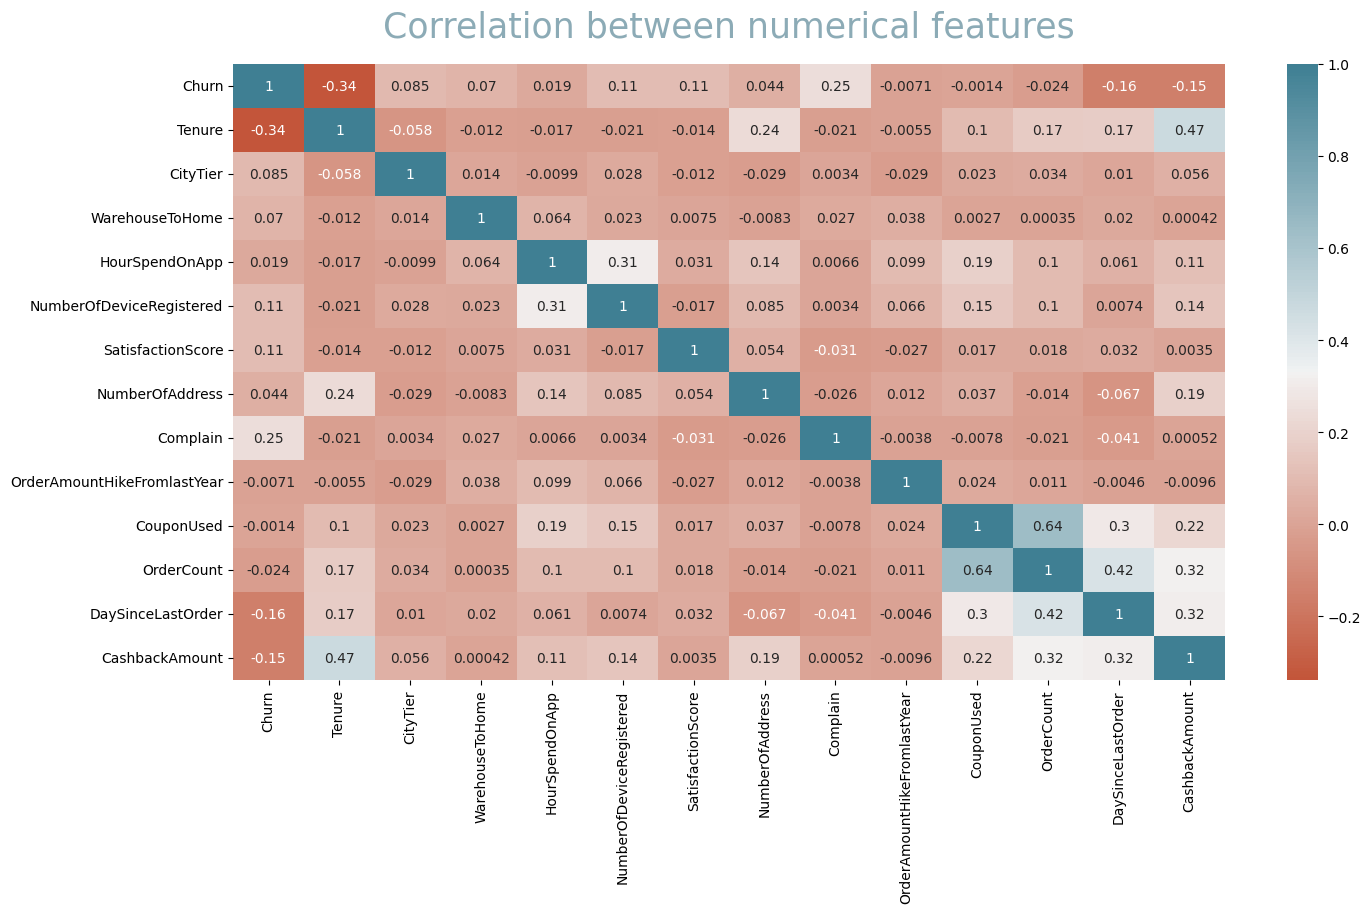

In [12]:
heat = df.corr(numeric_only=True)
plt.figure(figsize = [16,8])
plt.title("Correlation between numerical features", size = 25, pad = 20, color = '#8cabb6')
sns.heatmap(heat, cmap = sns.diverging_palette(20, 220, n = 200), annot = True)
plt.show()

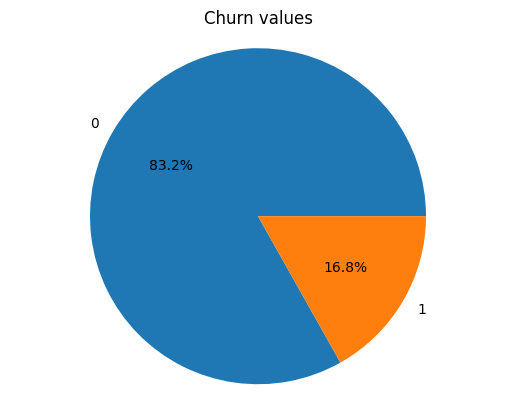

In [13]:
column_counts = df['Churn'].value_counts()
plt.pie(column_counts.values, labels=column_counts.index, autopct='%1.1f%%')
plt.title(f'Churn values')
plt.axis('equal')

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

df_processed = df.copy()

# Itera sobre cada coluna do dataframe
for col in df_processed.columns:
    # Verifica se a coluna é do tipo 'object' (categórica)
    if df_processed[col].dtype == 'object':
        le = LabelEncoder()
        # Aplica o LabelEncoder na coluna
        df_processed[col] = le.fit_transform(df_processed[col])

scaler = MinMaxScaler()
df_scaled_values = scaler.fit_transform(df_processed)
df_normalized = pd.DataFrame(df_scaled_values, columns=df_processed.columns, index=df_processed.index)
df = df_normalized


# Create train and test sets

In [363]:
# First we need to the data into 70% training dataset and 30% testing dataset
X = df.drop(['Churn'],axis=1)
y = df['Churn']

from  sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)
logreg_prediction = logreg.predict(X_test)
print('Accuracy Score: %s ' % accuracy_score(y_test, logreg_prediction))
print(classification_report(y_test, logreg_prediction))

Accuracy Score: 0.7933688573120189 
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.87      1414
         1.0       0.43      0.80      0.56       275

    accuracy                           0.79      1689
   macro avg       0.69      0.80      0.71      1689
weighted avg       0.87      0.79      0.82      1689



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()

logreg_pipeline = Pipeline([
    ('scaler', scaler),
    ('logreg', logreg)
])

logreg_result = evaluate_model_kfold(logreg_pipeline, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.869638       0.005975
F1-Score   0.560614       0.017192
Recall     0.815388       0.014296
Precision  0.427518       0.019629
Accuracy   0.784369       0.014960
---------------------------------------------


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler # Precisamos importar o Scaler manualmente
from sklearn.metrics import accuracy_score, classification_report
# Assumindo que X_train, y_train, X_test, y_test já existem.
# E que eles não têm valores ausentes. Se tiverem, um imputer seria necessário aqui.

# --- PASSO 1: PRÉ-PROCESSAMENTO MANUAL ---

# Criando o objeto para padronizar a escala
scaler = StandardScaler()

# "Aprende" a média e o desvio padrão dos dados de TREINO e os transforma
X_train_scaled = scaler.fit_transform(X_train)

# APLICA A MESMA transformação aprendida no treino aos dados de TESTE
# (É crucial usar apenas .transform() aqui para evitar vazamento de dados)
X_test_scaled = scaler.transform(X_test)


# --- PASSO 2: TREINAR E AVALIAR O SVM NOS DADOS PRÉ-PROCESSADOS ---

# Criando o modelo SVM. Usar class_weight='balanced' ainda é uma boa prática.
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)

scaler = StandardScaler()

svm_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('classifier', svm_model)
])

# Treinando o modelo com os dados de TREINO que foram escalonados
svm_pipeline.fit(X_train_scaled, y_train)


# Previsões nos dados de treino
y_train_pred = svm_pipeline.predict(X_train)
f1_treino = f1_score(y_train, y_train_pred)

# Previsões nos dados de teste
y_test_pred = svm_pipeline.predict(X_test)
f1_teste = f1_score(y_test, y_test_pred)
svm_prediction = svm_pipeline.predict(X_test)

print(f"F1-Score no Treino: {f1_treino:.4f}")
print(f"F1-Score no Teste:  {f1_teste:.4f}")

# Avaliando o modelo
print("--- Resultados do Modelo com SVM ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, svm_prediction))

print("\nClassification Report:")
print(classification_report(y_test, svm_prediction))

--- Resultados do Modelo com SVM ---
Accuracy Score: 0.8836589698046181 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      1885
         1.0       0.61      0.81      0.70       367

    accuracy                           0.88      2252
   macro avg       0.78      0.86      0.81      2252
weighted avg       0.90      0.88      0.89      2252



In [157]:
svm_tuned_result = evaluate_model_kfold(svm_pipeline, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.953470       0.005429
F1-Score   0.732287       0.020870
Recall     0.879805       0.037428
Precision  0.627994       0.023980
Accuracy   0.891652       0.009348
---------------------------------------------


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


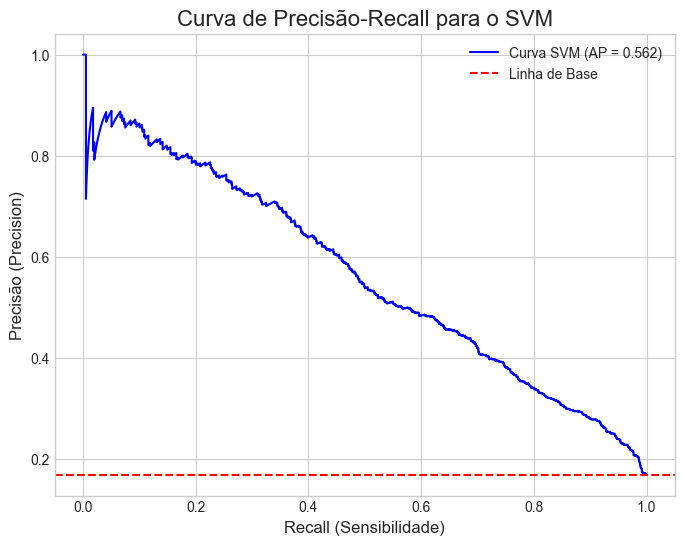

In [158]:
plot_precision_recall_curve(svm_model, X, y, model_name="SVM")

## Fine Tuning

In [168]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score, classification_report

# --- PASSO 1: CONFIGURAR O PIPELINE E O GRID DE HIPERPARÂMETROS ---

# Assumindo que X_train, y_train, X_test, y_test já existem.
# E que eles não têm valores ausentes.

# O Pipeline irá encapsular o pré-processamento e o modelo.
# Isso garante que a mesma escala seja aprendida no treino e aplicada no teste
# de forma automática e segura, inclusive durante a validação cruzada do GridSearchCV.
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])

# Definindo o "grid" de parâmetros que queremos testar.
# O nome de cada parâmetro DEVE conter o nome do passo no pipeline seguido por '__' (dois underlines).
# Ex: 'svm__C' para o parâmetro 'C' do passo 'svm'.
param_grid = {
    'svm__C': [0.1],  # Valores para o parâmetro de regularização C
    'svm__gamma': [0.1], # Valores para o coeficiente gamma
    'svm__kernel': ['rbf'] # Tipos de kernel a serem testados
}

# --- PASSO 2: EXECUTAR A BUSCA EM GRADE COM VALIDAÇÃO CRUZADA ---

# Criando o objeto GridSearchCV.
# - estimator: o pipeline que queremos otimizar.
# - param_grid: o dicionário com os parâmetros a serem testados.
# - cv: o número de "folds" (dobras) da validação cruzada (5 é um valor comum).
# - scoring: a métrica para avaliar qual combinação é a melhor (ex: 'accuracy', 'f1_macro').
# - n_jobs=-1: usa todos os processadores disponíveis para acelerar a busca.
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           verbose=1, # Mostra o progresso do treinamento
                           n_jobs=-1)

# "Fit" o GridSearchCV aos dados de TREINO.
# Ele irá automaticamente pré-processar e treinar o SVM para cada combinação.
# ESTE PASSO PODE DEMORAR BASTANTE!
grid_search.fit(X_train, y_train)


# --- PASSO 3: AVALIAR OS RESULTADOS ---

# Imprimir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados: ", grid_search.best_params_)

# Imprimir a melhor pontuação de acurácia durante a validação cruzada
print("\nMelhor score de acurácia (validação cruzada): {:.2f}%".format(grid_search.best_score_ * 100))

# O grid_search se comporta como um estimador e já está treinado com os melhores parâmetros.
# Agora, podemos usá-lo para fazer previsões nos dados de TESTE.
svm_tuned = grid_search.best_estimator_

# Previsões nos dados de treino
y_train_pred = svm_tuned.predict(X_train)
f1_treino = f1_score(y_train, y_train_pred)

# Previsões nos dados de teste
y_test_pred = svm_tuned.predict(X_test)
f1_teste = f1_score(y_test, y_test_pred)
svm_prediction = svm_tuned.predict(X_test)

print(f"F1-Score no Treino: {f1_treino:.4f}")
print(f"F1-Score no Teste:  {f1_teste:.4f}")


# Avaliando o modelo final com os melhores parâmetros nos dados de teste
print("\n--- Resultados do Modelo Otimizado no Conjunto de Teste ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, svm_prediction))

print("\nClassification Report:")
print(classification_report(y_test, svm_prediction))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Melhores parâmetros encontrados:  {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

Melhor score de acurácia (validação cruzada): 62.43%
F1-Score no Treino: 0.6902
F1-Score no Teste:  0.6155

--- Resultados do Modelo Otimizado no Conjunto de Teste ---
Accuracy Score: 0.8374777975133215 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      1885
         1.0       0.50      0.80      0.62       367

    accuracy                           0.84      2252
   macro avg       0.73      0.82      0.76      2252
weighted avg       0.88      0.84      0.85      2252



In [169]:
svm_tuned_result = evaluate_model_kfold(svm_tuned, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.912236       0.005899
F1-Score   0.638986       0.018220
Recall     0.850253       0.033556
Precision  0.512636       0.022306
Accuracy   0.838011       0.012717
---------------------------------------------


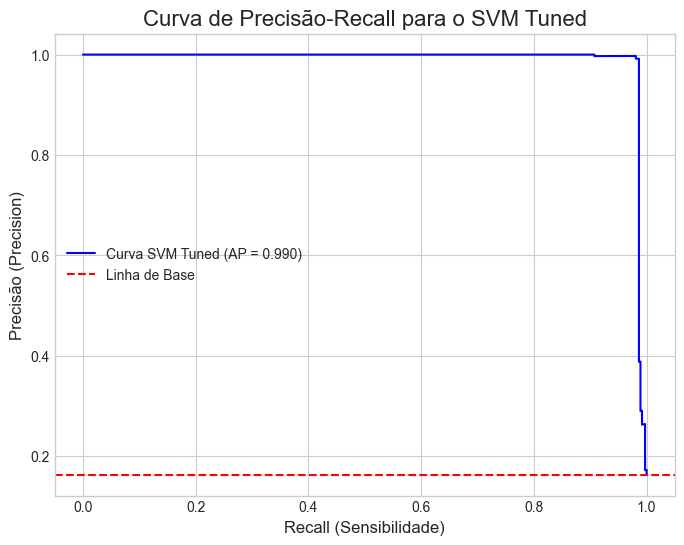

In [161]:
plot_precision_recall_curve(svm_tuned, X_test, y_test, model_name="SVM Tuned")

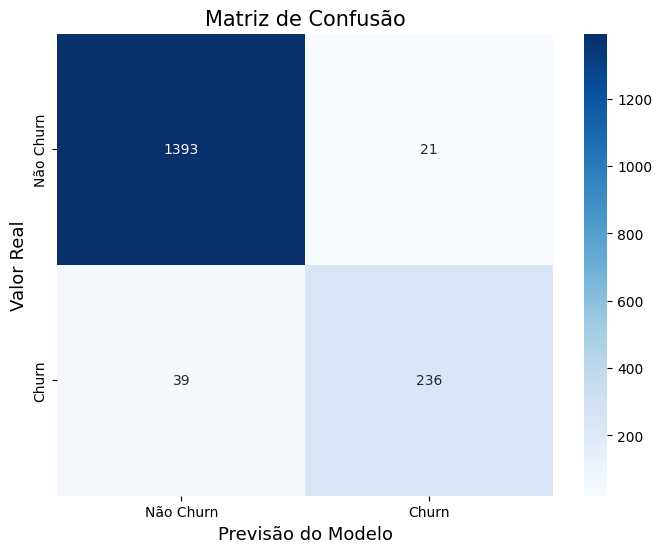

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, svm_prediction)

# 3. Criando o heatmap para visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])

plt.xlabel('Previsão do Modelo', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()

# Random Forest

In [55]:
# 1. Importando as bibliotecas necessárias
from sklearn.ensemble import RandomForestClassifier # Trocamos o modelo
from sklearn.metrics import accuracy_score, classification_report
# Assumindo que X_train, y_train, X_test, y_test já existem.

# --- PASSO 1: PRÉ-PROCESSAMENTO ---
# Não precisamos de StandardScaler para o Random Forest!
# Vamos usar os dados X_train e X_test diretamente.
# (Se houvesse dados ausentes, o passo de imputação ainda seria necessário aqui)


# --- PASSO 2: TREINAR E AVALIAR O RANDOM FOREST ---

# Criando o modelo Random Forest.
# Usar class_weight='balanced' ainda é uma boa prática para dados desbalanceados.
rf_model = RandomForestClassifier(n_estimators=500,
                                  random_state=42,
                                  n_jobs=-1) # Dica: n_jobs=-1 usa todos os núcleos do seu CPU para treinar mais rápido

# Treinando o modelo com os dados de TREINO originais (sem escalonamento)
rf_model.fit(X_train, y_train)

# Fazendo as previsões com os dados de TESTE originais
rf_prediction = rf_model.predict(X_test)

# Avaliando o modelo
print("--- Resultados do Modelo com Random Forest ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, rf_prediction))
print("\nClassification Report:")
print(classification_report(y_test, rf_prediction))

--- Resultados do Modelo com Random Forest ---
Accuracy Score: 0.9626998223801065 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1414
         1.0       0.93      0.84      0.88       275

    accuracy                           0.96      1689
   macro avg       0.95      0.91      0.93      1689
weighted avg       0.96      0.96      0.96      1689



In [56]:
rf_result = evaluate_model_kfold(rf_model, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.992052       0.001786
F1-Score   0.918134       0.022598
Recall     0.879811       0.037271
Precision  0.960716       0.006128
Accuracy   0.973712       0.006731
---------------------------------------------


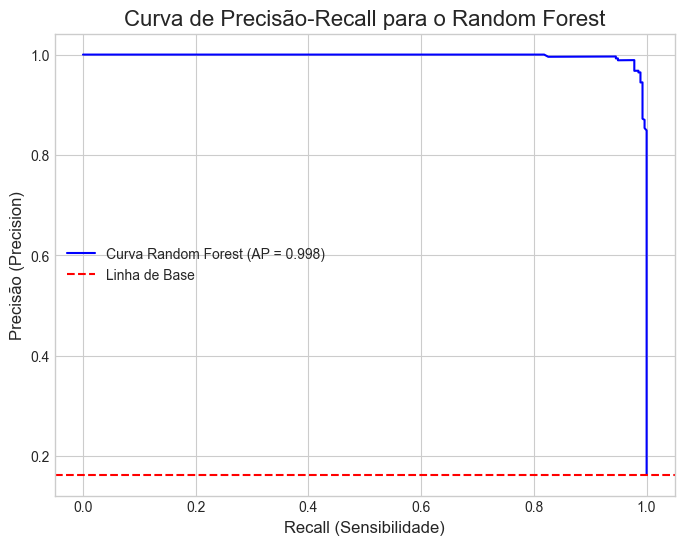

In [58]:
plot_precision_recall_curve(rf_model, X_test, y_test, model_name="Random Forest")

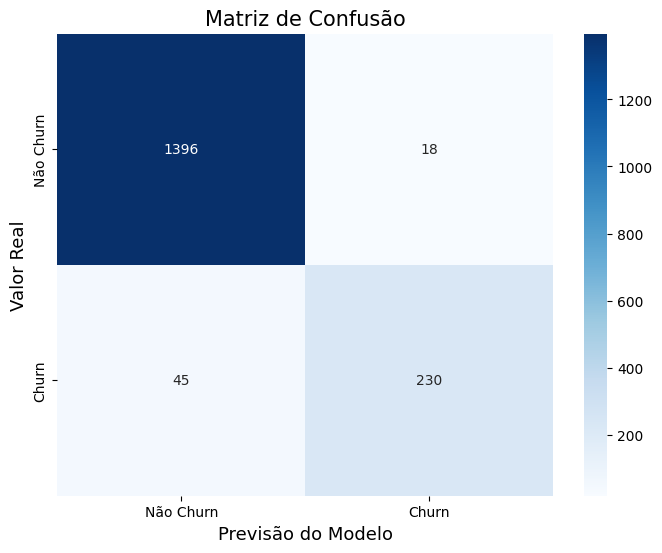

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, rf_prediction)

# 3. Criando o heatmap para visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])

plt.xlabel('Previsão do Modelo', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()

## Fine Tuning

In [27]:
from sklearn.model_selection import GridSearchCV

# O grid de parâmetros pode ser o mesmo ou até maior
param_dist = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [10, 20, 30, 40, 50, None],
    'max_features': ['sqrt', 'log2']
}

# Criando o modelo base
rf_base = RandomForestClassifier(random_state=42)

# Executando a busca em grade com validação cruzada
random_search = GridSearchCV(estimator=rf_base,
                            param_grid=param_dist,                                   
                            scoring='f1',
                            cv=3,
                            verbose=1,
                            n_jobs=-1)

print("Iniciando a busca de hiperparâmetros com RandomizedSearchCV...")
random_search.fit(X_train, y_train)


# --- AVALIAR OS RESULTADOS (o processo é idêntico ao do GridSearchCV) ---

print("\nMelhores parâmetros encontrados: ", random_search.best_params_)
print("\nMelhor score de F1 (validação cruzada): {:.4f}".format(random_search.best_score_))

best_model_tuned = random_search.best_estimator_
rf_prediction_tuned = best_model_tuned.predict(X_test)

print("\n--- Resultados do Modelo Otimizado (Random Search) no Conjunto de Teste ---")
print(classification_report(y_test, rf_prediction_tuned))

Iniciando a busca de hiperparâmetros com RandomizedSearchCV...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Melhores parâmetros encontrados:  {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 300}

Melhor score de F1 (validação cruzada): 0.8118

--- Resultados do Modelo Otimizado (Random Search) no Conjunto de Teste ---
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1414
         1.0       0.93      0.83      0.87       275

    accuracy                           0.96      1689
   macro avg       0.95      0.91      0.92      1689
weighted avg       0.96      0.96      0.96      1689



In [28]:
rf_result_tuned = evaluate_model_kfold(best_model_tuned, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.992081       0.001999
F1-Score   0.915196       0.020960
Recall     0.874531       0.034656
Precision  0.960503       0.004942
Accuracy   0.972824       0.006219
---------------------------------------------


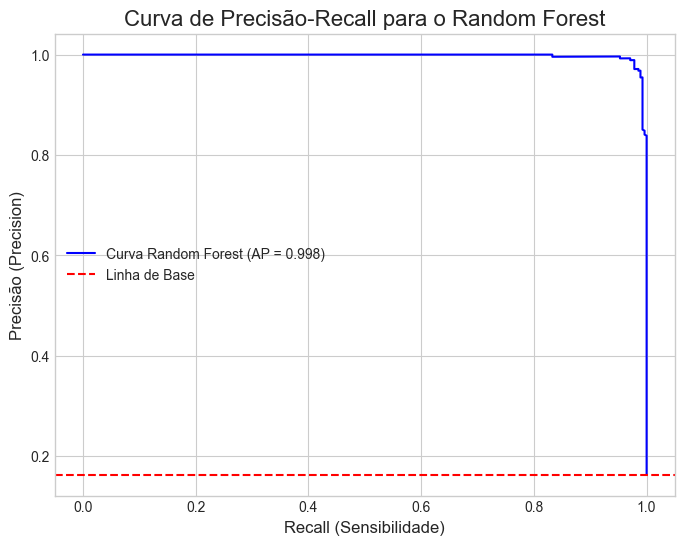

In [54]:
plot_precision_recall_curve(best_model_tuned, X_test, y_test, model_name='Random Forest')


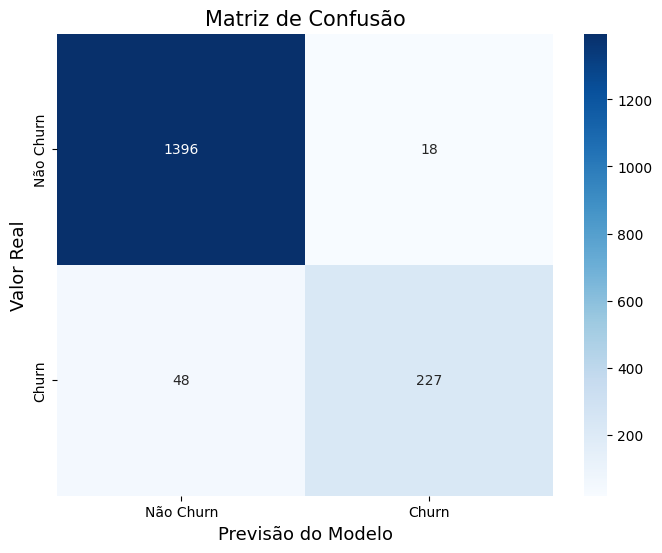

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, rf_prediction_tuned)

# 3. Criando o heatmap para visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])

plt.xlabel('Previsão do Modelo', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()

# XGB

In [364]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

eval_set = [(X_train, y_train), (X_test, y_test)]
def eval_recall(y_true, y_pred):
    """Métrica customizada de Recall para o XGBoost."""
    y_pred_class = (y_pred > 0.5).astype(int)
    score = recall_score(y_true, y_pred_class)
    return score
def eval_f1(y_true, y_pred):
    """Métrica customizada de F1-Score para o XGBoost."""
    y_pred_class = (y_pred > 0.5).astype(int)
    score = f1_score(y_true, y_pred_class)
    return score
def recall_metric(y_true, y_pred):
    # As previsões do XGBoost (y_pred) são probabilidades. Precisamos convertê-las para classes.
    y_pred_class = (y_pred > 0.5).astype(int)
    return recall_score(y_true, y_pred_class)

xgb = XGBClassifier(random_state=42,
                    eval_metric=eval_f1) # Ex: Para se o F1-Score não melhorar por 50 rodadas)
xgb.fit(X_train, 
        y_train,
        eval_set=eval_set,
        verbose=False)



# Previsões nos dados de treino
y_train_pred = xgb.predict(X_train)
f1_treino = f1_score(y_train, y_train_pred)

# Previsões nos dados de teste
xgb_prediction = xgb.predict(X_test)
f1_teste = f1_score(y_test, xgb_prediction)

print(f"F1-Score no Treino: {f1_treino:.4f}")
print(f"F1-Score no Teste:  {f1_teste:.4f}")

# Avaliando o modelo
print("--- Resultados do Modelo com XGBoost ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, xgb_prediction))
print("\nClassification Report:")
print(classification_report(y_test, xgb_prediction))

results = xgb.evals_result()

F1-Score no Treino: 1.0000
F1-Score no Teste:  0.8942
--- Resultados do Modelo com XGBoost ---
Accuracy Score: 0.9662522202486679 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1414
         1.0       0.91      0.88      0.89       275

    accuracy                           0.97      1689
   macro avg       0.94      0.93      0.94      1689
weighted avg       0.97      0.97      0.97      1689



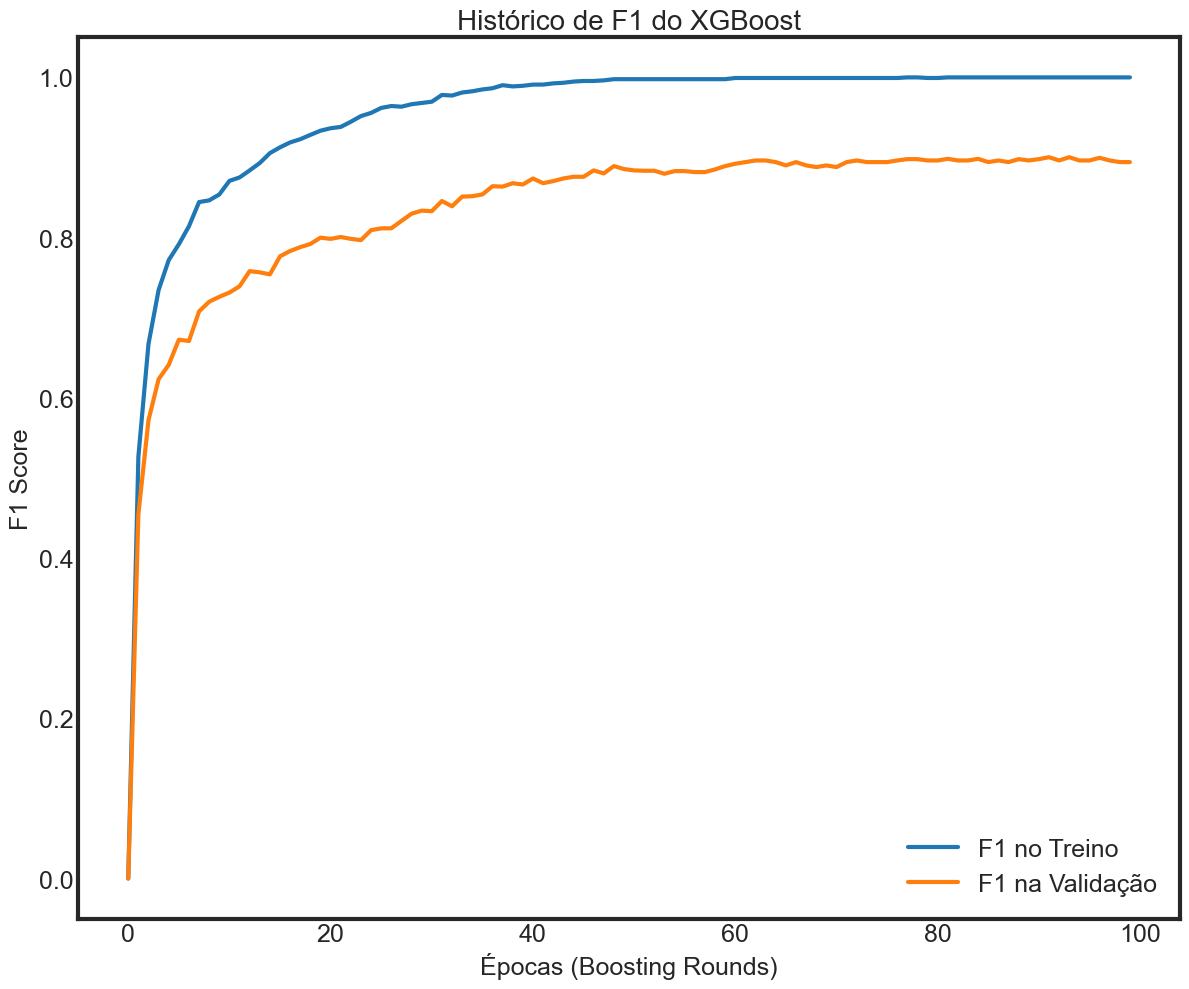

In [382]:
epochs = len(results['validation_0']['eval_f1'])
x_axis = range(0, epochs)

# Plotar as curvas
fig, ax = plt.subplots(figsize=(12, 10),)
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color("#272727")
ax.plot(x_axis, results['validation_0']['eval_f1'], label='F1 no Treino', linewidth=3)
ax.plot(x_axis, results['validation_1']['eval_f1'], label='F1 na Validação', linewidth=3)
ax.legend(fontsize=18)
plt.ylabel('F1 Score', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.xlabel('Épocas (Boosting Rounds)', fontsize=18)
plt.title('Histórico de F1 do XGBoost', fontsize=20)
plt.grid(False)
plt.tight_layout()
plt.savefig('historico_f1_xgboost_banner.png', dpi=300, bbox_inches='tight')

plt.show()

In [366]:
xgb_result = evaluate_model_kfold(xgb, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.985619       0.003154
F1-Score   0.928145       0.017006
Recall     0.902980       0.033014
Precision  0.955619       0.011793
Accuracy   0.976554       0.005166
---------------------------------------------


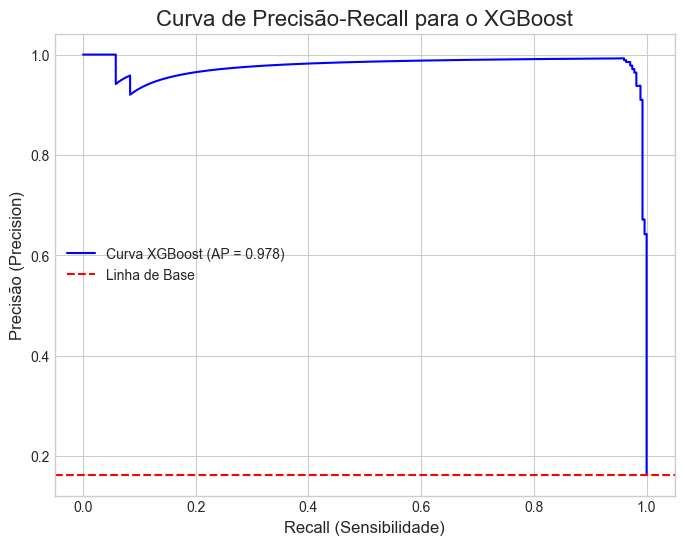

In [367]:
plot_precision_recall_curve(xgb, X_test, y_test, model_name='XGBoost')

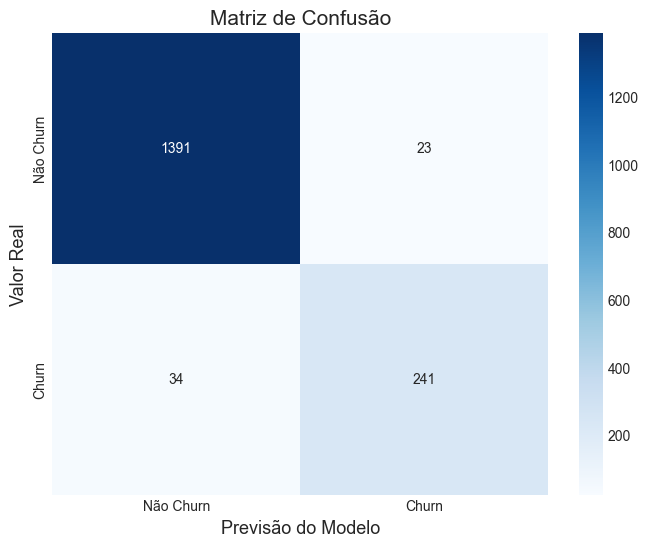

In [368]:
cm = confusion_matrix(y_test, xgb_prediction)

# 3. Criando o heatmap para visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])

plt.xlabel('Previsão do Modelo', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()

## Outro modelo

/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:31:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break


F1-Score no Treino: 0.8373
F1-Score no Teste:  0.7411

Relatório de Performance para Detecção de Churn
Threshold usado: 0.40

Métricas Chave:
Recall (Sensitividade): 0.9018
Precisão: 0.5976
F2-Score (prioriza recall): 0.8185
AUC-ROC: 0.9500

Matriz de Confusão:
Verdadeiros Negativos (TN): 1247
Falsos Positivos (FP): 167  (custo de retenção desnecessária)
Falsos Negativos (FN): 27  (CLIENTES PERDIDOS - CRÍTICO!)
Verdadeiros Positivos (TP): 248

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      1414
         1.0       0.60      0.90      0.72       275

    accuracy                           0.89      1689
   macro avg       0.79      0.89      0.82      1689
weighted avg       0.92      0.89      0.89      1689



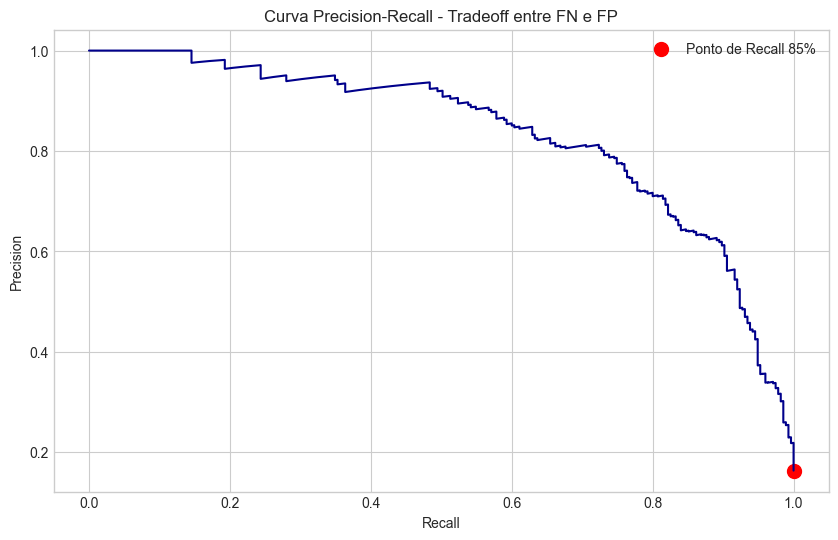


Threshold ótimo para recall mínimo de 85%: 0.0002


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, fbeta_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Calcular peso para a classe positiva (churn)
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos  # Peso inversamente proporcional à frequência

# 2. Configurar modelo com foco em recall
model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,  # Penaliza mais erros na classe minoritária
    eval_metric=['logloss', 'auc', 'aucpr'],
    max_depth=3,  # Profundidade menor para evitar overfitting
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.5,
    gamma=0.5,  # Regularização mais forte
    reg_alpha=0.1,
    reg_lambda=1,
    n_estimators=300,
    random_state=42,
    use_label_encoder=False,
)

# 3. Treinar com foco em recall
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    
    verbose=False
)

# Previsões nos dados de treino
y_train_pred = model.predict(X_train)
f1_treino = f1_score(y_train, y_train_pred)

# Previsões nos dados de teste
xgb_prediction = model.predict(X_test)
f1_teste = f1_score(y_test, xgb_prediction)

print(f"F1-Score no Treino: {f1_treino:.4f}")
print(f"F1-Score no Teste:  {f1_teste:.4f}")

# 4. Prever probabilidades (não classes)
y_proba = model.predict_proba(X_test)[:, 1]

# 5. Ajustar threshold para priorizar recall
threshold = 0.4  # Threshold mais baixo para capturar mais positivos
y_pred = (y_proba >= threshold).astype(int)

# 6. Métricas com foco em falsos negativos
print("\n" + "="*60)
print("Relatório de Performance para Detecção de Churn")
print("="*60)
print(f"Threshold usado: {threshold:.2f}")

print("\nMétricas Chave:")
print(f"Recall (Sensitividade): {recall_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"F2-Score (prioriza recall): {fbeta_score(y_test, y_pred, beta=2):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Matriz de confusão detalhada
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("\nMatriz de Confusão:")
print(f"Verdadeiros Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}  (custo de retenção desnecessária)")
print(f"Falsos Negativos (FN): {fn}  (CLIENTES PERDIDOS - CRÍTICO!)")
print(f"Verdadeiros Positivos (TP): {tp}")

# 8. Relatório completo
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# 9. Curva Precision-Recall (para análise de tradeoff)
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkblue')
plt.scatter(recall[np.argmax(recall >= 0.85)], precision[np.argmax(recall >= 0.85)], 
            color='red', s=100, label='Ponto de Recall 85%')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Tradeoff entre FN e FP')
plt.legend()
plt.grid(True)
plt.show()

# 10. Otimização automática do threshold (opcional)
def find_optimal_threshold(y_true, probas, min_recall=0.85):
    _, recall, thresholds = precision_recall_curve(y_true, probas)
    idx = np.argmax(recall >= min_recall)
    return thresholds[idx]

optimal_threshold = find_optimal_threshold(y_test, y_proba, min_recall=0.85)
print(f"\nThreshold ótimo para recall mínimo de 85%: {optimal_threshold:.4f}")

results = model.evals_result()

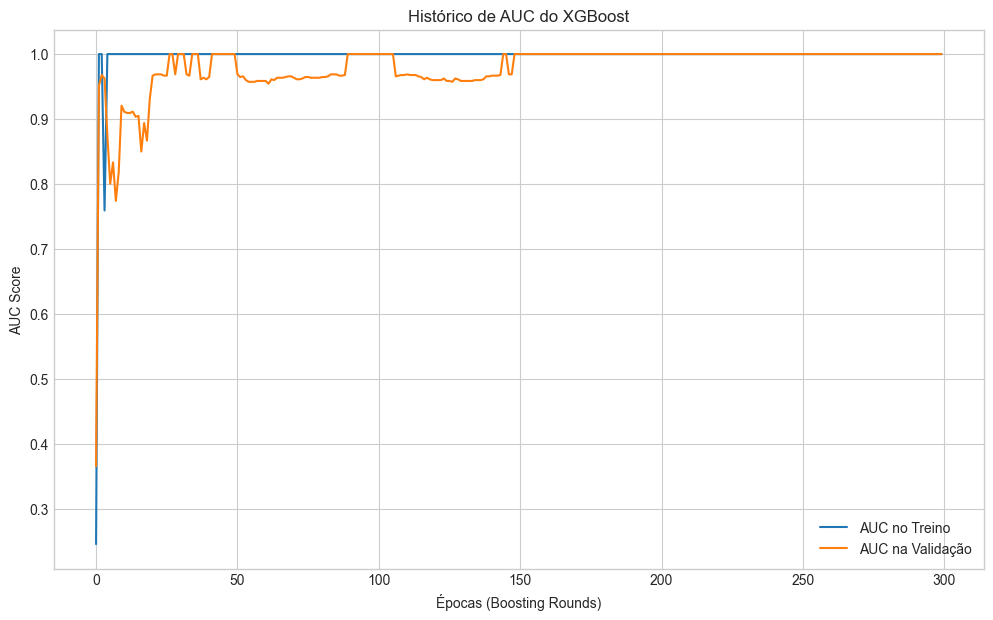

In [337]:
epochs = len(results['validation_0']['map'])
x_axis = range(0, epochs)

# Plotar as curvas
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_axis, results['validation_0']['map'], label='AUC no Treino')
ax.plot(x_axis, results['validation_1']['map'], label='AUC na Validação')
ax.legend()
plt.ylabel('AUC Score')
plt.xlabel('Épocas (Boosting Rounds)')
plt.title('Histórico de AUC do XGBoost')
plt.grid(True)
plt.show()

In [231]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import f1_score, classification_report, precision_recall_curve

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Vamos criar uma distribuição de parâmetros para explorar ao redor da sua configuração inicial
param_dist = {
    'learning_rate': [0.05, 0.08, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'subsample': [0.9],
    'colsample_bytree': [0.7],
    'gamma': [0.3, 0.5, 0.7],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# n_iter: quantas combinações aleatórias testar. 50 a 100 é um bom número.
param_sampler = ParameterSampler(param_dist, n_iter=200, random_state=42)

best_f1_val = -1
best_params = None

print(f"Iniciando busca de 60 combinações de hiperparâmetros...")

for i, params in enumerate(param_sampler):
    # n_estimators alto, pois o early stopping vai encontrar o ideal
    model_iter = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss', # Métrica para o early stopping
        n_estimators=1000,
        early_stopping_rounds=40,
        random_state=42,
        **params # Desempacota os parâmetros da iteração
    )

    model_iter.fit(X_train_sub, y_train_sub,
                   eval_set=[(X_val, y_val)],
                   verbose=False)

    # Avaliando o F1-Score no conjunto de validação
    preds_val = model_iter.predict(X_val)
    f1_val = f1_score(y_val, preds_val)

    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_params = params
        best_params['n_estimators'] = model_iter.best_iteration
        print(f"Iter {i+1}: Novo melhor F1 na validação: {best_f1_val:.4f} com {model_iter.best_iteration} estimadores.")
        print("Melhores parâmetros até agora:", best_params)

print("\n--- Fim da Busca ---")
print("Melhores parâmetros encontrados:", best_params)

# --- ETAPA 1.2: TREINAR O MODELO FINAL COM OS MELHORES HIPERPARÂMETROS ---
print("\nTreinando o modelo final com os melhores parâmetros em TODOS os dados de treino...")

final_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    **best_params
)

# Treinar nos dados de treino COMPLETOS
final_model.fit(X_train, y_train)

Iniciando busca de 60 combinações de hiperparâmetros...
Iter 1: Novo melhor F1 na validação: 0.8857 com 893 estimadores.
Melhores parâmetros até agora: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 893}
Iter 5: Novo melhor F1 na validação: 0.9025 com 622 estimadores.
Melhores parâmetros até agora: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7, 'n_estimators': 622}
Iter 28: Novo melhor F1 na validação: 0.9032 com 411 estimadores.
Melhores parâmetros até agora: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7, 'n_estimators': 411}
Iter 48: Novo melhor F1 na validação: 0.9039 com 549 estimadores.
Melhores parâmetros até agora: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [230]:
# Previsões nos dados de treino
y_train_pred = final_model.predict(X_train)
f1_treino = f1_score(y_train, y_train_pred)

# Previsões nos dados de teste
xgb_prediction = final_model.predict(X_test)
f1_teste = f1_score(y_test, xgb_prediction)

print(f"F1-Score no Treino: {f1_treino:.4f}")
print(f"F1-Score no Teste:  {f1_teste:.4f}")

F1-Score no Treino: 0.9956
F1-Score no Teste:  0.8973


In [227]:
xgb_result = evaluate_model_kfold(model, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:11:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break
/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:11:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break


--- Processando Fold 3/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break
/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break


--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.958869       0.006363
F1-Score   0.763699       0.023241
Recall     0.868176       0.021917
Precision  0.682805       0.035760
Accuracy   0.909236       0.011530
---------------------------------------------


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break


### Fine Tuning

In [46]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, fbeta_score
import time

# 1. Configurar métricas prioritárias (recall e F2-Score)
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

scoring = {
    'recall': make_scorer(recall_score),
    'f2_score': make_scorer(f2_score),
    'fbeta': make_scorer(fbeta_score, beta=2)
}

# 2. Espaço de busca de hiperparâmetros
param_dist = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 5, 10],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [1, 1.5, 2, 3, 5]  # Valores ao redor da proporção real
}

# 3. Configurar modelo base
base_model = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

# 4. Busca aleatória com validação cruzada estratificada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=100,  # Número de combinações testadas
    scoring=scoring,
    refit='fbeta',  # Usar F2-Score para selecionar o melhor modelo
    cv=kfold,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 5. Executar o tuning
print("Iniciando busca de hiperparâmetros...")
start_time = time.time()
random_search.fit(X_train, y_train)
print(f"Tuning concluído em {time.time() - start_time:.2f} segundos")

# 6. Resultados do tuning
print("\nMelhores hiperparâmetros encontrados:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nMelhor F2-Score (validação cruzada): {random_search.best_score_:.4f}")

# 7. Treinar modelo final com todos os dados de treino
final_model = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    random_state=42,
)

final_model.fit(X_train, y_train)

# 8. Avaliar no conjunto de teste
y_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.4).astype(int)  # Threshold otimizado para recall

print("\nPerformance no conjunto de teste:")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F2-Score: {f2_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")

Iniciando busca de hiperparâmetros...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuning concluído em 11.61 segundos

Melhores hiperparâmetros encontrados:
subsample: 0.8
scale_pos_weight: 3
reg_lambda: 1
reg_alpha: 0.1
n_estimators: 300
min_child_weight: 5
max_depth: 7
learning_rate: 0.05
gamma: 0.2
colsample_bytree: 0.7

Melhor F2-Score (validação cruzada): 0.8697

Performance no conjunto de teste:
Recall: 0.9018
F2-Score: 0.8832
Precisão: 0.8158


In [47]:
xgb_result = evaluate_model_kfold(model, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:47:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break
/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:47:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break


--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:47:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break
/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:47:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break


--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.970354       0.004142
F1-Score   0.796656       0.018293
Recall     0.881866       0.023663
Precision  0.727884       0.034665
Accuracy   0.923979       0.009102
---------------------------------------------


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:47:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  break


# Feature engineering

In [74]:
def add_features_to_set(df):
    df_new_features = df.copy()

    # Lógica condicional: se OrderCount for 0, o resultado é 0. Caso contrário, faz a divisão.
    df_new_features['cashback_per_order'] = np.where(
        df['OrderCount'] == 0, 0, df['CashbackAmount'] / df['OrderCount']
    )
    df_new_features['avg_hour_spend_on_app_per_order'] = np.where(
        df['OrderCount'] == 0, 0, df['HourSpendOnApp'] / df['OrderCount']
    )

    df_new_features['satisfaction_score_after_complain'] = df['Complain'] * df['SatisfactionScore']

    # A coluna Tenure + 1 provavelmente não precisa de tratamento, pois Tenure >= 0
    df_new_features['cashback_amount_per_month'] = df['CashbackAmount'] / (df['Tenure'] + 1)

    df_new_features['satisfaction_score_2'] = df['SatisfactionScore'] * df['Complain']
    df_new_features['tenure_2'] =  df['Tenure'] * df['Tenure']
    df_new_features['tenure_3'] =  df['Tenure'] * df['Tenure'] * df['Tenure']
    df_new_features['DaySinceLastOrder_2'] = df['DaySinceLastOrder'] * df['DaySinceLastOrder']
    df_new_features['cashback_amount_per_month_2'] = df_new_features['cashback_amount_per_month'] * df_new_features['cashback_amount_per_month']

    return df_new_features

X_train_2 = add_features_to_set(X_train)
X_test_2 = add_features_to_set(X_test)

# SVM com Feature Engineering

In [76]:
# Assumindo que X_train, y_train, X_test, y_test já existem.
# E que eles não têm valores ausentes. Se tiverem, um imputer seria necessário aqui.

# --- PASSO 1: PRÉ-PROCESSAMENTO MANUAL ---

# Criando o objeto para padronizar a escala
scaler = StandardScaler()

# "Aprende" a média e o desvio padrão dos dados de TREINO e os transforma
X_train_scaled = scaler.fit_transform(X_train_2)

# APLICA A MESMA transformação aprendida no treino aos dados de TESTE
# (É crucial usar apenas .transform() aqui para evitar vazamento de dados)
X_test_scaled = scaler.transform(X_test_2)


# --- PASSO 2: TREINAR E AVALIAR O SVM NOS DADOS PRÉ-PROCESSADOS ---

# Criando o modelo SVM. Usar class_weight='balanced' ainda é uma boa prática.
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)

# Treinando o modelo com os dados de TREINO que foram escalonados
svm_model.fit(X_train_scaled, y_train)

# Fazendo as previsões com os dados de TESTE que foram escalonados
svm_prediction = svm_model.predict(X_test_scaled)

# Avaliando o modelo
print("--- Resultados do Modelo com SVM ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, svm_prediction))
print("\nClassification Report:")
print(classification_report(y_test, svm_prediction))

--- Resultados do Modelo com SVM ---
Accuracy Score: 0.872113676731794 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92      1414
         1.0       0.57      0.86      0.69       275

    accuracy                           0.87      1689
   macro avg       0.77      0.87      0.80      1689
weighted avg       0.90      0.87      0.88      1689



In [77]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# --- PASSO 1: CONFIGURAR O PIPELINE E O GRID DE HIPERPARÂMETROS ---

# Assumindo que X_train, y_train, X_test, y_test já existem.
# E que eles não têm valores ausentes.

# O Pipeline irá encapsular o pré-processamento e o modelo.
# Isso garante que a mesma escala seja aprendida no treino e aplicada no teste
# de forma automática e segura, inclusive durante a validação cruzada do GridSearchCV.
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])

# Definindo o "grid" de parâmetros que queremos testar.
# O nome de cada parâmetro DEVE conter o nome do passo no pipeline seguido por '__' (dois underlines).
# Ex: 'svm__C' para o parâmetro 'C' do passo 'svm'.
param_grid = {
    'svm__C': [30, 50, 80, 100, 150],  # Valores para o parâmetro de regularização C
    'svm__gamma': [0.1], # Valores para o coeficiente gamma
    'svm__kernel': ['rbf'] # Tipos de kernel a serem testados
}

# --- PASSO 2: EXECUTAR A BUSCA EM GRADE COM VALIDAÇÃO CRUZADA ---

# Criando o objeto GridSearchCV.
# - estimator: o pipeline que queremos otimizar.
# - param_grid: o dicionário com os parâmetros a serem testados.
# - cv: o número de "folds" (dobras) da validação cruzada (5 é um valor comum).
# - scoring: a métrica para avaliar qual combinação é a melhor (ex: 'accuracy', 'f1_macro').
# - n_jobs=-1: usa todos os processadores disponíveis para acelerar a busca.
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           verbose=1, # Mostra o progresso do treinamento
                           n_jobs=-1)

# "Fit" o GridSearchCV aos dados de TREINO.
# Ele irá automaticamente pré-processar e treinar o SVM para cada combinação.
# ESTE PASSO PODE DEMORAR BASTANTE!
grid_search.fit(X_train_scaled, y_train)


# --- PASSO 3: AVALIAR OS RESULTADOS ---

# Imprimir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados: ", grid_search.best_params_)

# Imprimir a melhor pontuação de acurácia durante a validação cruzada
print("\nMelhor score de acurácia (validação cruzada): {:.2f}%".format(grid_search.best_score_ * 100))

# O grid_search se comporta como um estimador e já está treinado com os melhores parâmetros.
# Agora, podemos usá-lo para fazer previsões nos dados de TESTE.
svm_tuned = grid_search.best_estimator_
svm_prediction = svm_tuned.predict(X_test_scaled)


# Avaliando o modelo final com os melhores parâmetros nos dados de teste
print("\n--- Resultados do Modelo Otimizado no Conjunto de Teste ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, svm_prediction))

print("\nClassification Report:")
print(classification_report(y_test, svm_prediction))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores parâmetros encontrados:  {'svm__C': 30, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

Melhor score de acurácia (validação cruzada): 81.53%

--- Resultados do Modelo Otimizado no Conjunto de Teste ---
Accuracy Score: 0.9538188277087034 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1414
         1.0       0.89      0.81      0.85       275

    accuracy                           0.95      1689
   macro avg       0.93      0.90      0.91      1689
weighted avg       0.95      0.95      0.95      1689



In [78]:
evaluate_model_kfold(svm_tuned, X, y)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.988684       0.010049
F1-Score   0.930000       0.021209
Recall     0.907229       0.034901
Precision  0.954847       0.018897
Accuracy   0.977087       0.006608
---------------------------------------------


,Média,Desvio Padrão
AUC,0.988684,0.010049
F1-Score,0.930000,0.021209
Recall,0.907229,0.034901
Precision,0.954847,0.018897
Accuracy,0.977087,0.006608


# Random Forest com Feature Engineering

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight='balanced',
                                  random_state=42,
                                  n_jobs=-1) # Dica: n_jobs=-1 usa todos os núcleos do seu CPU para treinar mais rápido

# Treinando o modelo com os dados de TREINO originais (sem escalonamento)
rf_model.fit(X_train, y_train)

# Fazendo as previsões com os dados de TESTE originais
rf_prediction = rf_model.predict(X_test_2)

# Avaliando o modelo
print("--- Resultados do Modelo com Random Forest ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, rf_prediction))
print("\nClassification Report:")
print(classification_report(y_test, rf_prediction))

--- Resultados do Modelo com Random Forest ---
Accuracy Score: 0.9591474245115453 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1414
         1.0       0.92      0.83      0.87       275

    accuracy                           0.96      1689
   macro avg       0.94      0.91      0.92      1689
weighted avg       0.96      0.96      0.96      1689



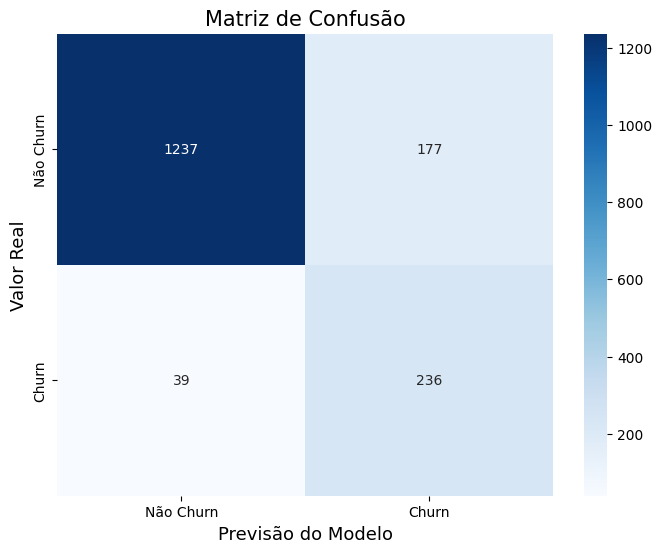

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, svm_prediction)

# 3. Criando o heatmap para visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])

plt.xlabel('Previsão do Modelo', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()

# XGB com Feature Engineering

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_2, y_train)
xgb_prediction = xgb.predict(X_test_2)

# Avaliando o modelo
print("--- Resultados do Modelo com XGBoost ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, xgb_prediction))
print("\nClassification Report:")
print(classification_report(y_test, xgb_prediction))

--- Resultados do Modelo com XGBoost ---
Accuracy Score: 0.9632918886915335 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1414
         1.0       0.92      0.85      0.88       275

    accuracy                           0.96      1689
   macro avg       0.94      0.92      0.93      1689
weighted avg       0.96      0.96      0.96      1689



In [ ]:
xgb_result = evaluate_model_kfold(xgb, X_train_2, y_train)

Iniciando avaliação com K-Fold (5 dobras)...
--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---

--- Resultado da Avaliação com K-Fold ---
              Média  Desvio Padrão
AUC        0.970140       0.005445
F1-Score   0.861334       0.023320
Recall     0.831962       0.039539
Precision  0.895229       0.036057
Accuracy   0.954327       0.007484
---------------------------------------------


# MLP

In [487]:
# Importando as bibliotecas necessárias do TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model():
    # Supondo que X_train_scaled já existe e está pré-processado
    # Determinar o número de features de entrada
    n_features = X_train.shape[1]

    # --- 1. Construindo a Arquitetura ---
    model = Sequential()



    # Segunda Camada Oculta
    model.add(Dense(256, activation='relu', input_shape=(n_features,)))
    model.add(Dropout(0.4)) # Camada de Dropout para regularização

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4)) # Camada de Dropout para regularização

    # Camada de Saída
    model.add(Dense(1, activation='sigmoid'))

    adam_optimizer = Adam(learning_rate=0.001) # Experimente valores como 0.0005, 0.0001

    # --- 2. Compilando o Modelo ---
    # Este passo configura o processo de treinamento
    model.compile(optimizer=adam_optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', 'recall', 'precision']) # AUC é uma ótima métrica para problemas de churn
    return model

# Criando o modelo
model = create_model()

# --- 3. Visualizando a Arquitetura ---
# Imprime um resumo claro do seu modelo
model.summary()

/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_596 (Dense)               │ (None, 256)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_357 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_358 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,913 (277.00 KB)

 Trainable params: 70,913 (277.00 KB)

 Non-trainable params: 0 (0.00 B)

In [488]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight


early_stopper = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train), # Classes presentes nos seus dados (ex: [0, 1])
    y=y_train                  # Seus rótulos de treino
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',      # Métrica a ser monitorada
    factor=0.2,              # Fator de redução (new_lr = lr * factor). Ex: 0.001 -> 0.0002
    patience=18,              # Nº de épocas sem melhora antes de reduzir a LR
    min_lr=0.0000001,          # Limite inferior para a taxa de aprendizado
    verbose=1                # Imprime uma mensagem quando a LR é atualizada
)

# Crie o dicionário que o Keras espera: {classe: peso}
class_weight_dict = dict(zip(np.unique(y_train), weights))





# --- Treinando o modelo ---
history = model.fit(
    X_train,          # Features de treino (com engenharia e escalonadas)
    y_train,                 # Rótulos de treino
    epochs=300,              # Um número máximo de épocas. O EarlyStopping vai parar antes se necessário.
    batch_size=32,           # Tamanho do lote. 32 é um bom valor padrão.
    validation_data=(X_test, y_test), # Dados para validar o modelo a cada época
    callbacks=[early_stopper, lr_scheduler], # Lista de callbacks para usar durante o treino
    verbose=1,                # 1 para mostrar a barra de progresso
    #class_weight=class_weight_dict,
)

Epoch 1/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5141 - accuracy: 0.7924 - loss: 0.4918 - precision: 0.1344 - recall: 0.0570 - val_AUC: 0.7911 - val_accuracy: 0.8544 - val_loss: 0.3631 - val_precision: 0.6495 - val_recall: 0.2291 - learning_rate: 0.0010
Epoch 2/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8052 - accuracy: 0.8467 - loss: 0.3642 - precision: 0.6523 - recall: 0.2255 - val_AUC: 0.8372 - val_accuracy: 0.8674 - val_loss: 0.3325 - val_precision: 0.7931 - val_recall: 0.2509 - learning_rate: 0.0010
Epoch 3/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8566 - accuracy: 0.8546 - loss: 0.3367 - precision: 0.6804 - recall: 0.3888 - val_AUC: 0.8519 - val_accuracy: 0.8804 - val_loss: 0.3163 - val_precision: 0.8230 - val_recall: 0.3382 - learning_rate: 0.0010
Epoch 4/300
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8446 - accuracy: 0.8692 - loss: 0.3246 - precision: 0.6923 - recall: 0.3573 - val_AUC: 0.8551 - val_accuracy: 0.8851 - val_loss: 0.3095 -

In [485]:
model_prediction = model.predict(X_test)
model_prediction = (model_prediction > 0.5).astype("int32")

print("--- Resultados do Modelo com MLP ---")
print('Accuracy Score: %s ' % accuracy_score(y_test, model_prediction))
print("\nClassification Report:")
print(classification_report(y_test, model_prediction))

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
--- Resultados do Modelo com MLP ---
Accuracy Score: 0.9425695677915926 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1414
         1.0       0.91      0.72      0.80       275

    accuracy                           0.94      1689
   macro avg       0.93      0.85      0.88      1689
weighted avg       0.94      0.94      0.94      1689



In [477]:
def kfold():
    n_splits = 5

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics_results = {
        'AUC': [],
        'F1-Score': [],
        'Recall': [],
        'Precision': [],
        'Accuracy': []
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"--- Processando Fold {fold + 1}/{n_splits} ---")

        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

        # Para Keras, o pré-processamento (scaling) deve ser feito aqui dentro
        # ou o modelo já deve ser um pipeline que o inclua.
        # Vamos assumir que X e y já estão pré-processados por simplicidade.
        model = create_model()  # Recriar o modelo para cada fold
        # Treinar o modelo
        model.fit(X_train_fold, y_train_fold, epochs=100, verbose=0, # verbose=0 para não poluir a saída
                    callbacks=[EarlyStopping(monitor='loss', patience=10)]) # Um EarlyStopping simples

        # Fazer previsões (retorna probabilidades para modelos Keras)
        y_pred_proba = model.predict(X_val_fold)

        # ------------------- INÍCIO DA CORREÇÃO -------------------

        # Para AUC, usamos as probabilidades diretamente
        metrics_results['AUC'].append(roc_auc_score(y_val_fold, y_pred_proba))

        # Para as outras métricas, convertemos as probabilidades em classes (0 ou 1)
        # usando um limiar de 0.5
        y_pred_classes = (y_pred_proba > 0.5).astype("int32")

        # ------------------- FIM DA CORREÇÃO -------------------

        # Calcular e armazenar as métricas usando as classes previstas
        metrics_results['F1-Score'].append(f1_score(y_val_fold, y_pred_classes))
        metrics_results['Recall'].append(recall_score(y_val_fold, y_pred_classes))
        metrics_results['Precision'].append(precision_score(y_val_fold, y_pred_classes))
        metrics_results['Accuracy'].append(accuracy_score(y_val_fold, y_pred_classes))

        # Calcular a média e o desvio padrão dos resultados
    summary_df = pd.DataFrame(metrics_results).agg(['mean', 'std']).T
    print("\n--- Resultado da Avaliação com K-Fold ---")
    print(summary_df)
    print("-" * 45)

kfold()

--- Processando Fold 1/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Processando Fold 2/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Processando Fold 3/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Processando Fold 4/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Processando Fold 5/5 ---


/home/luka-gouvea/Área de trabalho/INF420/trabalho final/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

--- Resultado da Avaliação com K-Fold ---
               mean       std
AUC        0.981752  0.005050
F1-Score   0.861351  0.021313
Recall     0.810192  0.054013
Precision  0.922497  0.025737
Accuracy   0.956306  0.005525
---------------------------------------------


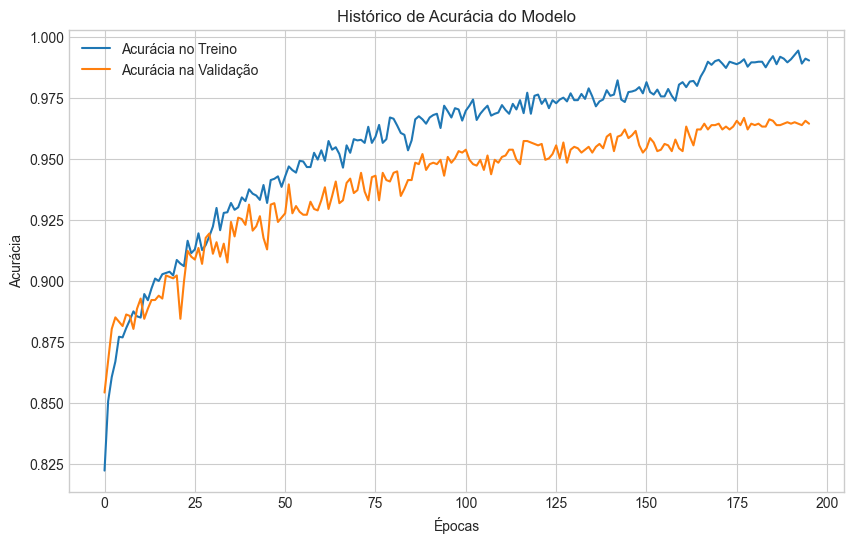

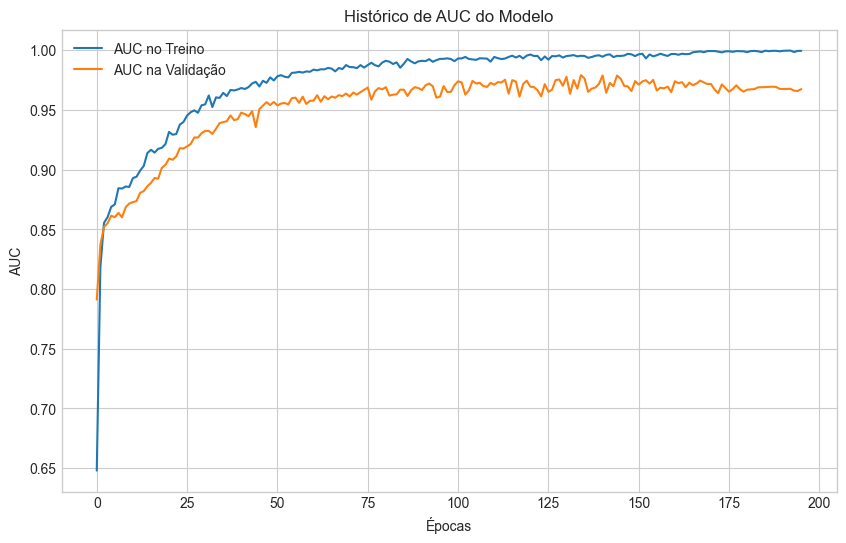

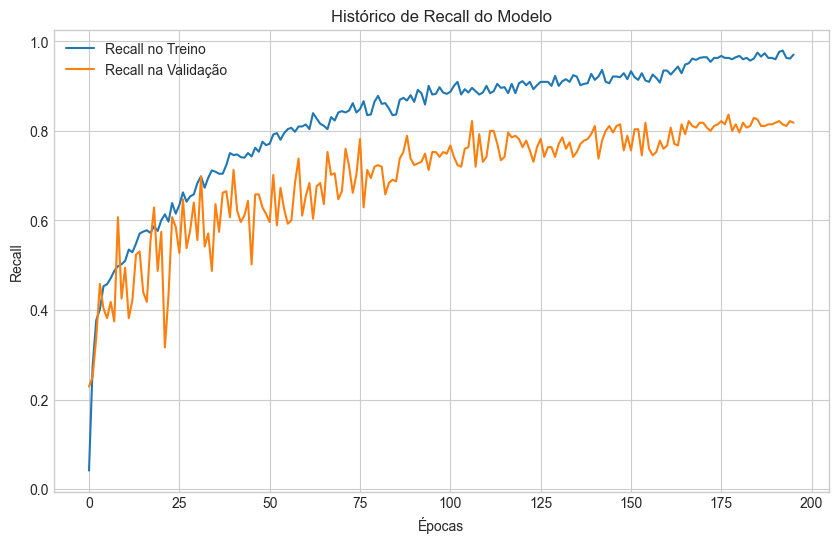

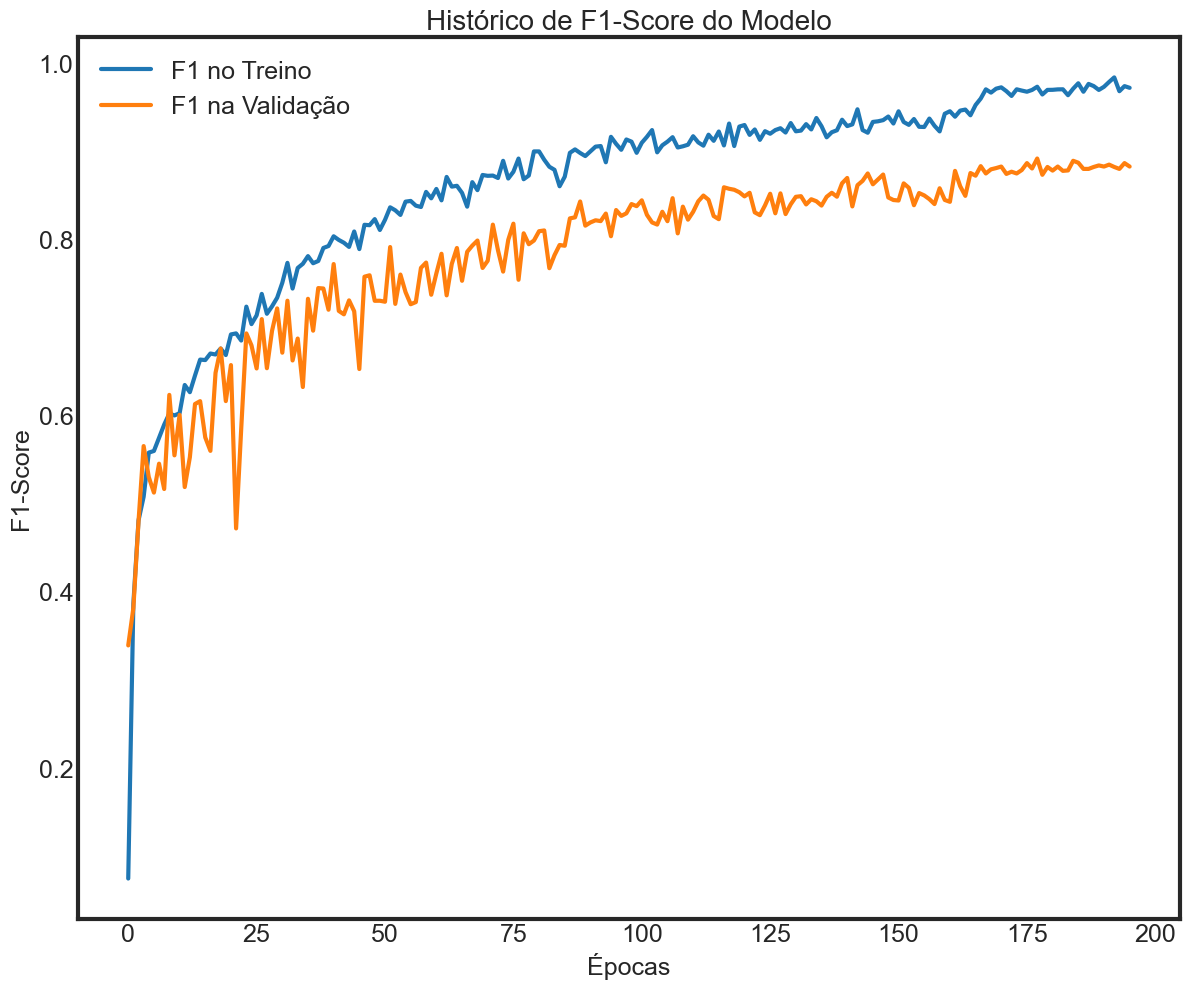

In [489]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Acurácia no Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Histórico de Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history.history['AUC'], label='AUC no Treino')
plt.plot(history.history['val_AUC'], label='AUC na Validação')
plt.title('Histórico de AUC do Modelo')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], label='Recall no Treino')
plt.plot(history.history['val_recall'], label='Recall na Validação')
plt.title('Histórico de Recall do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

# PASSO 1: Extrair as listas de métricas do histórico
recall_treino_list = history.history['recall']
precision_treino_list = history.history['precision']
recall_val_list = history.history['val_recall']
precision_val_list = history.history['val_precision']

# PASSO 2: Converter as listas para arrays NumPy para permitir operações matemáticas
recall_treino = np.array(recall_treino_list)
precision_treino = np.array(precision_treino_list)
recall_val = np.array(recall_val_list)
precision_val = np.array(precision_val_list)

# PASSO 3: Calcular o F1-Score usando a fórmula correta
# Adicionamos uma pequena constante (epsilon) no denominador para evitar divisão por zero no início do treino
epsilon = 1e-7
f1_treino = 2 * (precision_treino * recall_treino) / (precision_treino + recall_treino + epsilon)
f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + epsilon)



# PASSO 4: Plotar o gráfico com os valores de F1 calculados
fig, ax = plt.subplots(figsize=(12, 10))
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color("#272727")
plt.plot(f1_treino, label='F1 no Treino', linewidth=3)
plt.plot(f1_val, label='F1 na Validação', linewidth=3)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.title('Histórico de F1-Score do Modelo', fontsize=20)
plt.xlabel('Épocas', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.grid(False)
plt.tight_layout()
plt.savefig('historico_f1_ann_banner.png', dpi=300, bbox_inches='tight')

plt.show()

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

--- Relatório de Classificação Final ---
              precision    recall  f1-score   support

   Não Churn       0.92      0.37      0.53      1414
       Churn       0.20      0.83      0.33       275

    accuracy                           0.45      1689
   macro avg       0.56      0.60      0.43      1689
weighted avg       0.80      0.45      0.50      1689


--- Matriz de Confusão ---


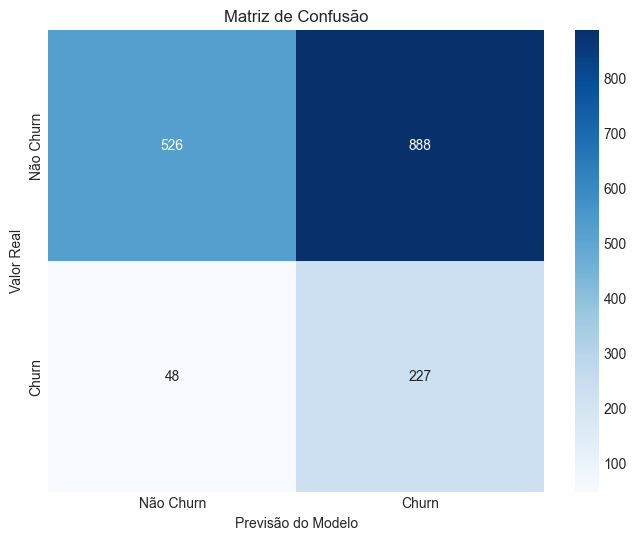

In [393]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Fazer previsões no conjunto de teste (o resultado serão probabilidades)
y_pred_proba = model.predict(X_test)

# 2. Converter as probabilidades em classes binárias (0 ou 1)
# Usamos um limiar de 0.5. Se a probabilidade for > 0.5, classificamos como 1 (Churn).
y_pred_classes = (y_pred_proba > 0.5).astype("int32")

# 3. Gerar o Classification Report
print("\n--- Relatório de Classificação Final ---")
print(classification_report(y_test, y_pred_classes, target_names=['Não Churn', 'Churn']))

# 4. Gerar a Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.xlabel('Previsão do Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

# Rede Residual

In [357]:
from tensorflow.keras.layers import Input, Dense, Dropout, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_resnet_model():
    n_features = X_train.shape[1]

    def residual_block(x, units, dropout_rate=0.35):
        shortcut = x
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
        x = Dense(units, activation=None)(x)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x

    inputs = Input(shape=(n_features,))

    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.4)(x)

    # Bloco residual 1
    x = residual_block(x, 128)


    outputs = Dense(1, activation='sigmoid')(x)

    resnet_model = Model(inputs, outputs)
    resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'AUC', 'recall', 'precision'])
    return resnet_model

resnet_model = create_resnet_model()
resnet_model.summary()

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_271 (Dense)   │ (None, 128)       │      2,432 │ input_layer_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_146         │ (None, 128)       │          0 │ dense_271[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_272 (Dense)   │ (None, 128)       │     16,512 │ dropout_146[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_147         │ (None, 128)       │          0 │ dense_272[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_273 (Dense)   │ (None, 128)       │     16,512 │ dropout_147[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_148         │ (None, 128)       │          0 │ dense_273[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_274 (Dense)   │ (None, 128)       │     16,512 │ dropout_148[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 128)       │          0 │ dense_274[0][0],  │
│                     │                   │            │ dropout_146[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 128)       │          0 │ add_56[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_275 (Dense)   │ (None, 1)         │        129 │ activation_54[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,097 (203.50 KB)

 Trainable params: 52,097 (203.50 KB)

 Non-trainable params: 0 (0.00 B)

In [359]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001)


history_resnet = resnet_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stopper],
    verbose=1
)

Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.4909 - accuracy: 0.8143 - loss: 0.4916 - precision: 0.0337 - recall: 0.0012 - val_AUC: 0.7793 - val_accuracy: 0.8490 - val_loss: 0.3860 - val_precision: 0.7000 - val_recall: 0.1273 - learning_rate: 0.0010
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7713 - accuracy: 0.8324 - loss: 0.3877 - precision: 0.5351 - recall: 0.0968 - val_AUC: 0.8228 - val_accuracy: 0.8632 - val_loss: 0.3560 - val_precision: 0.6089 - val_recall: 0.4473 - learning_rate: 0.0010
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8310 - accuracy: 0.8415 - loss: 0.3612 - precision: 0.6165 - recall: 0.3399 - val_AUC: 0.8438 - val_accuracy: 0.8751 - val_loss: 0.3249 - val_precision: 0.8478 - val_recall: 0.2836 - learning_rate: 0.0010
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8406 - accuracy: 0.8585 - loss: 0.3364 - precision: 0.6803 - recall: 0.3296 - val_AUC: 0.8544 - val_accuracy: 0.8798 - val_loss: 0.3055 -

In [360]:
from sklearn.metrics import classification_report

y_pred_resnet = resnet_model.predict(X_test)
y_pred_resnet = (y_pred_resnet > 0.5).astype("int32")
print(classification_report(y_test, y_pred_resnet))

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1414
         1.0       0.91      0.74      0.82       275

    accuracy                           0.95      1689
   macro avg       0.93      0.86      0.89      1689
weighted avg       0.94      0.95      0.94      1689



In [358]:
def kfold():
    n_splits = 5

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics_results = {
        'AUC': [],
        'F1-Score': [],
        'Recall': [],
        'Precision': [],
        'Accuracy': []
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"--- Processando Fold {fold + 1}/{n_splits} ---")

        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

        # Para Keras, o pré-processamento (scaling) deve ser feito aqui dentro
        # ou o resnet_modelo já deve ser um pipeline que o inclua.
        # Vamos assumir que X e y já estão pré-processados por simplicidade.
        resnet_model = create_resnet_model()  # Recriar o modelo para cada fold
        # Treinar o resnet_modelo
        resnet_model.fit(X_train_fold, y_train_fold, epochs=100, verbose=0, # verbose=0 para não poluir a saída
                    callbacks=[EarlyStopping(monitor='loss', patience=10)]) # Um EarlyStopping simples

        # Fazer previsões (retorna probabilidades para resnet_modelos Keras)
        y_pred_proba = resnet_model.predict(X_val_fold)

        # ------------------- INÍCIO DA CORREÇÃO -------------------

        # Para AUC, usamos as probabilidades diretamente
        metrics_results['AUC'].append(roc_auc_score(y_val_fold, y_pred_proba))

        # Para as outras métricas, convertemos as probabilidades em classes (0 ou 1)
        # usando um limiar de 0.5
        y_pred_classes = (y_pred_proba > 0.5).astype("int32")

        # ------------------- FIM DA CORREÇÃO -------------------

        # Calcular e armazenar as métricas usando as classes previstas
        metrics_results['F1-Score'].append(f1_score(y_val_fold, y_pred_classes))
        metrics_results['Recall'].append(recall_score(y_val_fold, y_pred_classes))
        metrics_results['Precision'].append(precision_score(y_val_fold, y_pred_classes))
        metrics_results['Accuracy'].append(accuracy_score(y_val_fold, y_pred_classes))

        # Calcular a média e o desvio padrão dos resultados
    summary_df = pd.DataFrame(metrics_results).agg(['mean', 'std']).T
    print("\n--- Resultado da Avaliação com K-Fold ---")
    print(summary_df)
    print("-" * 45)

kfold()

--- Processando Fold 1/5 ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Processando Fold 2/5 ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Processando Fold 3/5 ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Processando Fold 4/5 ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--- Processando Fold 5/5 ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Resultado da Avaliação com K-Fold ---
               mean       std
AUC        0.977646  0.007327
F1-Score   0.834414  0.030676
Recall     0.769050  0.039117
Precision  0.912946  0.033161
Accuracy   0.948668  0.009344
---------------------------------------------


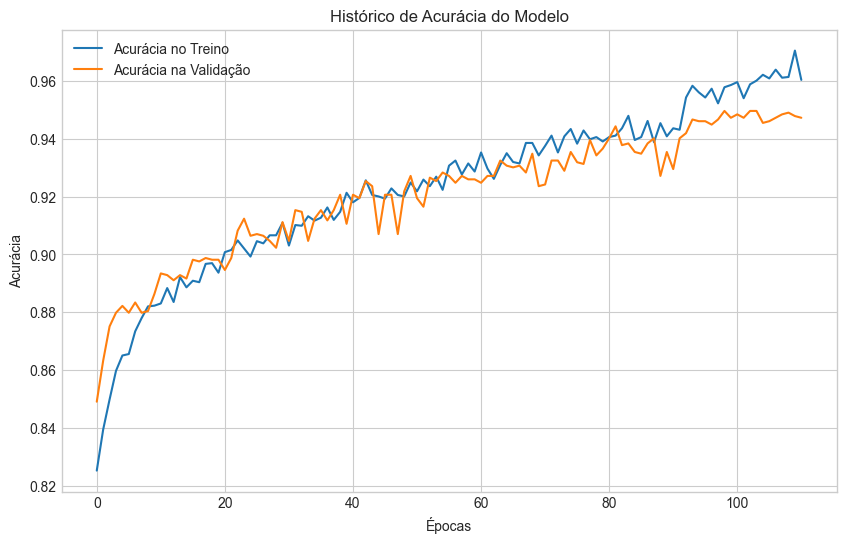

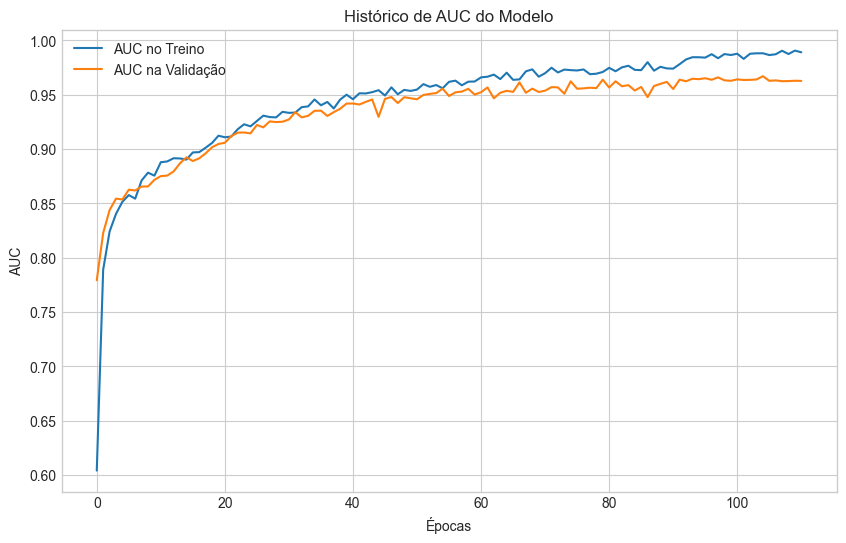

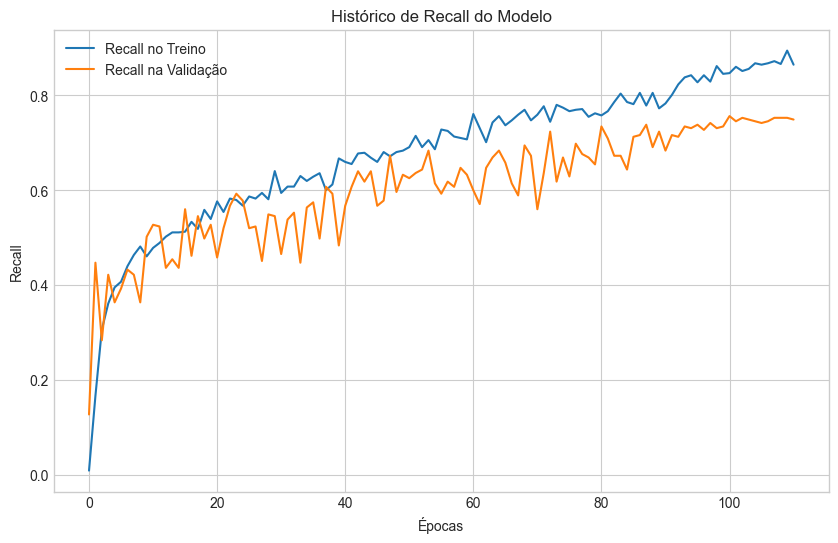

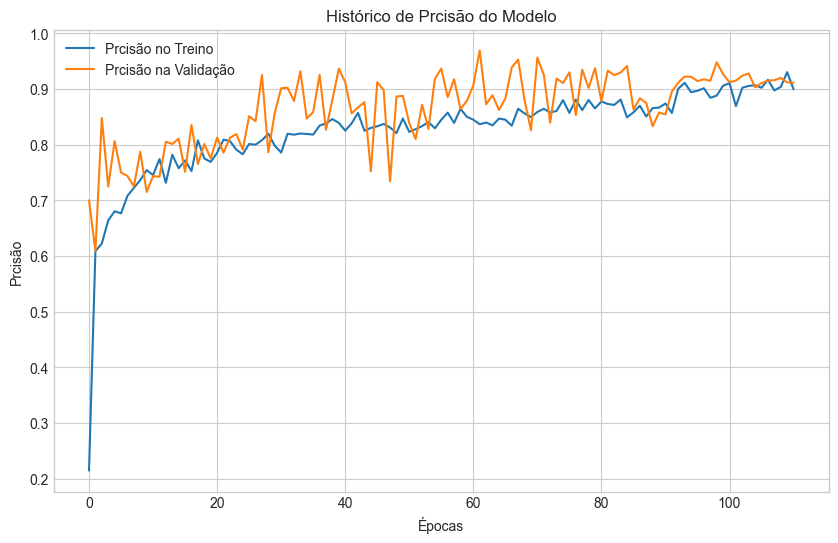

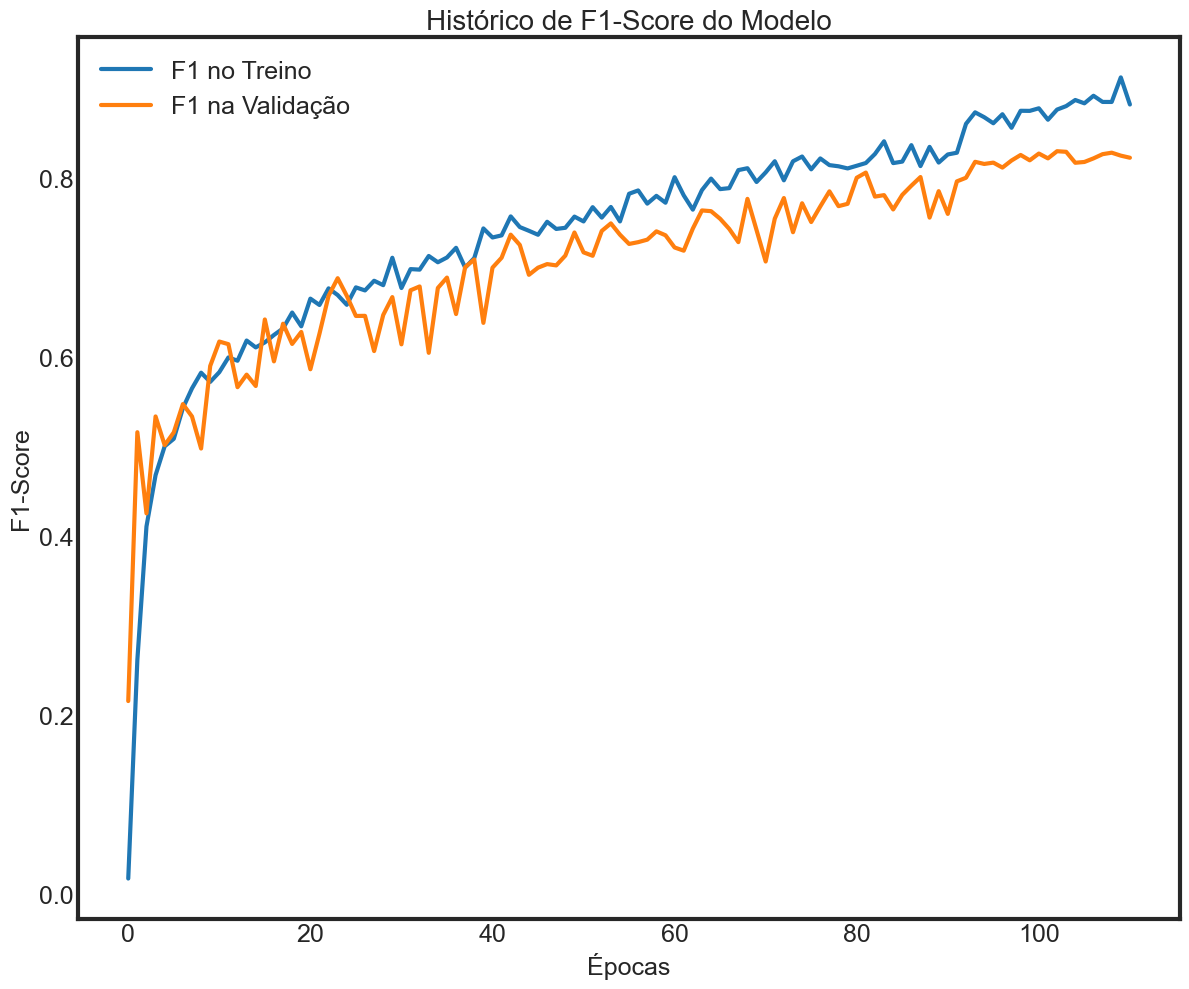

In [386]:
plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['accuracy'], label='Acurácia no Treino')
plt.plot(history_resnet.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Histórico de Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['AUC'], label='AUC no Treino')
plt.plot(history_resnet.history['val_AUC'], label='AUC na Validação')
plt.title('Histórico de AUC do Modelo')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['recall'], label='Recall no Treino')
plt.plot(history_resnet.history['val_recall'], label='Recall na Validação')
plt.title('Histórico de Recall do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(history_resnet.history['precision'], label='Prcisão no Treino')
plt.plot(history_resnet.history['val_precision'], label='Prcisão na Validação')
plt.title('Histórico de Prcisão do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Prcisão')
plt.legend()
plt.grid(True)
plt.show()


# PASSO 1: Extrair as listas de métricas do histórico
recall_treino_list = history_resnet.history['recall']
precision_treino_list = history_resnet.history['precision']
recall_val_list = history_resnet.history['val_recall']
precision_val_list = history_resnet.history['val_precision']

# PASSO 2: Converter as listas para arrays NumPy para permitir operações matemáticas
recall_treino = np.array(recall_treino_list)
precision_treino = np.array(precision_treino_list)
recall_val = np.array(recall_val_list)
precision_val = np.array(precision_val_list)

# PASSO 3: Calcular o F1-Score usando a fórmula correta
# Adicionamos uma pequena constante (epsilon) no denominador para evitar divisão por zero no início do treino
epsilon = 1e-7
f1_treino = 2 * (precision_treino * recall_treino) / (precision_treino + recall_treino + epsilon)
f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + epsilon)



# PASSO 4: Plotar o gráfico com os valores de F1 calculados
fig, ax = plt.subplots(figsize=(12, 10))
for spine in ax.spines.values():
    spine.set_linewidth(3)
    spine.set_color("#272727")
plt.plot(f1_treino, label='F1 no Treino', linewidth=3)
plt.plot(f1_val, label='F1 na Validação', linewidth=3)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.title('Histórico de F1-Score do Modelo', fontsize=20)
plt.xlabel('Épocas', fontsize=18)
plt.ylabel('F1-Score', fontsize=18)
plt.grid(False)
plt.tight_layout()
plt.savefig('historico_f1_resnet_banner.png', dpi=300, bbox_inches='tight')

plt.show()

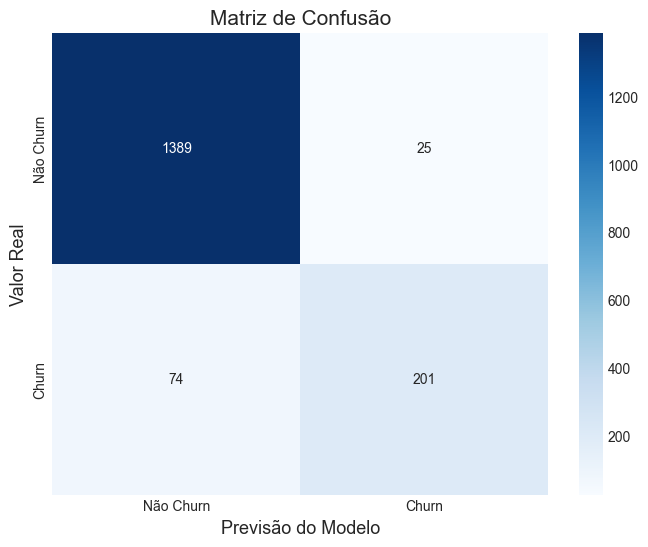

In [311]:
cm = confusion_matrix(y_test, y_pred_resnet)

# 3. Criando o heatmap para visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])

plt.xlabel('Previsão do Modelo', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=15)
plt.show()